In [80]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import pickle
import random
import importlib
import sys

import shap
from pdpbox import pdp
import matplotlib.pyplot as plt
import japanize_matplotlib

In [81]:
import common

# モジュールの再読み込み
importlib.reload(common)

_common = common.Common()
_common.BASE_PATH

PosixPath('/Users/iwasakitakahiro/github')

In [82]:
common_func_path = _common.COMMON_FUNC_PATH
sys.path.append(str(common_func_path))

import func

importlib.reload(func)

<module 'func' from '/Users/iwasakitakahiro/github/共通関数/func.py'>

In [83]:
train_df = pd.read_csv('../output/中間データ/学習用データ/train_preprocessed.csv')
train_df.head()

,price_actual,generation_biomass,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other_renewable,generation_solar,...,gene_sum_scaled,total_load_actual_exp_mean_to_t,total_load_actual_exp_std_to_t,total_load_actual_scaled,weighted_wind_speed,weighted_temp,weighted_pressure,weighted_dew_point,weighted_clouds_all,encoded_price_weekday_hour
0,54.70,448.0,4857.0,4581.0,157.0,973.0,1371.0,7099.0,73.0,50.0,...,-6.172131,24883.50,501.500000,-4.286142,1.493827,273.378658,1005.708505,270.403014,0.000000,48.250000
1,54.91,438.0,4314.0,4131.0,160.0,949.0,779.0,7098.0,75.0,50.0,...,-3.854295,24167.00,1092.891882,-2.636125,1.493827,273.361152,1005.708505,270.385650,0.000000,46.785000
2,53.07,428.0,4130.0,3840.0,156.0,953.0,720.0,7097.0,74.0,42.0,...,-2.155527,23446.75,1565.914968,-2.032518,1.493827,273.361995,1005.734568,270.390270,0.260631,45.661429
3,54.23,410.0,4038.0,3590.0,156.0,952.0,743.0,7098.0,74.0,34.0,...,-1.772386,22810.20,1892.737531,-1.534920,1.102881,272.899560,1006.657064,269.739788,0.156379,47.605000
4,58.22,401.0,4040.0,3368.0,158.0,961.0,848.0,7098.0,74.0,34.0,...,-1.482900,22326.00,2039.026156,-1.135836,1.102881,272.894287,1006.657064,269.738265,0.338820,53.155714


In [84]:
# 再現性確保のための固定シード
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Optunaのシードも固定
sampler = optuna.samplers.TPESampler(seed=SEED)

# LightGBMにも同様に
default_params = {
    'objective': 'quantile',
    # 'objective': 'huber',
    # 'alpha': 0.9,
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'random_state': SEED,
    'verbosity': -1
}

In [85]:
tscv = TimeSeriesSplit(n_splits=36)

#### 外れ値

In [86]:
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import IsolationForest

OUTLIER_COLS = ['price_actual', 'total_load_actual', 'residual_demand_ratio']

In [87]:
# CONTAM_LIST = [0.005, 0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25]
# RESULTS = []
# FEATURE_COLS = X_train.columns.to_list()

# for cont in CONTAM_LIST:
#     # --- ① 外れ値検出 ---
#     iso = IsolationForest(
#         n_estimators=300,
#         contamination=cont,
#         random_state=42
#     )
#     outliers = iso.fit_predict(train_df[OUTLIER_COLS]) == -1
#     weights  = np.where(outliers, 0.2, 1.0)        # ←倍率は後で一緒に最適化してもOK

#     # --- ② LightGBM で時系列 CV ---
#     rmses = []
#     for tr_idx, val_idx in tscv.split(train_df):
#         lgb_train = lgb.Dataset(
#             train_df.loc[tr_idx, FEATURE_COLS], train_df.loc[tr_idx, 'price_actual'],
#             weight=weights[tr_idx]
#         )
#         lgb_val   = lgb.Dataset(
#             train_df.loc[val_idx, FEATURE_COLS], train_df.loc[val_idx, 'price_actual'],
#             weight=weights[val_idx]
#         )
#         model = lgb.train(default_params,
#                           lgb_train,
#                           valid_sets=[lgb_val],
#                           num_boost_round=3000,
#                           callbacks=[
#                               lgb.early_stopping(50),
#                           ],
#         )
#         pred  = model.predict(train_df.loc[val_idx, FEATURE_COLS],
#                               num_iteration=model.best_iteration)
#         rmses.append(np.sqrt(mean_squared_error(train_df.loc[val_idx, 'price_actual'], pred)))
#     RESULTS.append((cont, np.mean(rmses)))

# for c, r in RESULTS:
#     print(f'cont={c:4.3f}  CV_RMSE={r:5.3f}')

In [88]:
iso = IsolationForest(
    n_estimators=300,
    contamination=0.01,   # 全体の 1 % を外れ値とみなす（要チューニング）
    random_state=42,
)
train_df['outlier_flag'] = iso.fit_predict(train_df[OUTLIER_COLS]) == -1

In [89]:
train_df[_common.UNIQUE_KEY_COLS] = pd.to_datetime(train_df[_common.UNIQUE_KEY_COLS], utc=True)
start = pd.Timestamp('2015-08-01 00:00:00', tz='UTC')
end   = pd.Timestamp('2016-05-31 23:59:59', tz='UTC')  # 末日まで含めたい場合

mask = train_df['time'].between(start, end)

# Isolation Forest で 0 だった行も 1 にする
train_df.loc[mask, 'outlier_flag'] = True

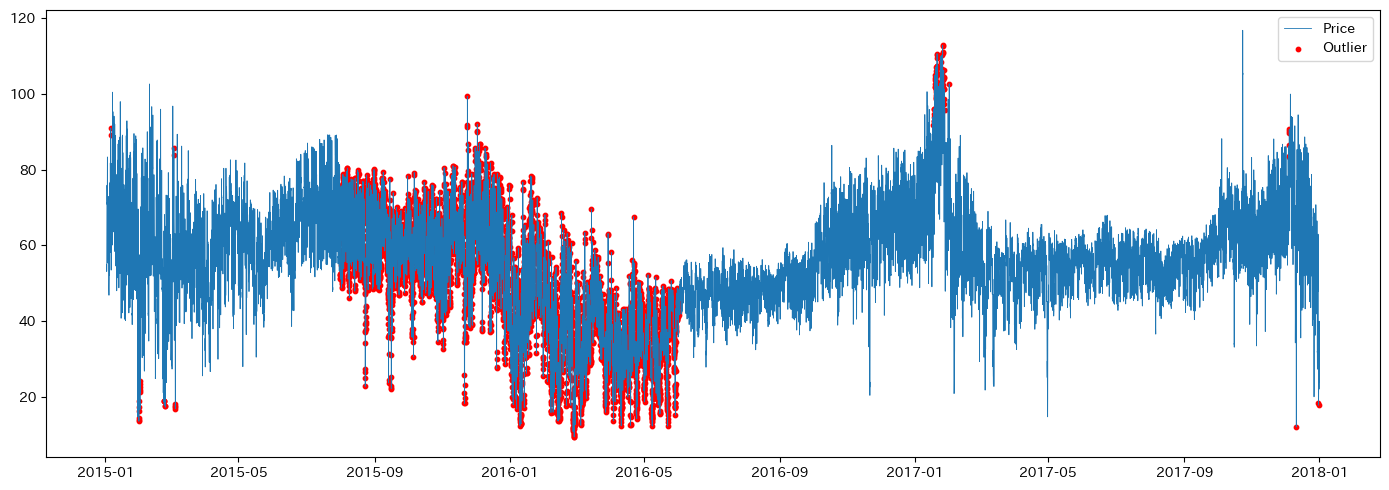

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(train_df['time'], train_df['price_actual'], lw=0.6, label='Price')
plt.scatter(train_df.loc[train_df.outlier_flag, 'time'],
            train_df.loc[train_df.outlier_flag, 'price_actual'],
            s=10, c='r', label='Outlier')
plt.legend(); plt.tight_layout()

#### ハイパーパラメータチューニング

In [91]:
train_df['weight'] = np.where(train_df['outlier_flag'], 0.2, 1.0)

In [92]:
train_df.columns

Index(['price_actual', 'generation_biomass', 'generation_fossil_gas',
       'generation_fossil_hard_coal', 'generation_fossil_oil',
       'generation_hydro_run_of_river_and_poundage',
       'generation_hydro_water_reservoir', 'generation_nuclear',
       'generation_other_renewable', 'generation_solar',
       'generation_wind_onshore', 'total_load_actual', 'time', 'gene_sum',
       'gene_load_ratio', 'residual_demand', 'residual_demand_ratio',
       'high_cost_ratio', 'tight_supply_flag', 'hour', 'weekday', 'month',
       'quarter', 'dayofyear', 'gene_sum_exp_mean_to_t',
       'gene_sum_exp_std_to_t', 'gene_sum_scaled',
       'total_load_actual_exp_mean_to_t', 'total_load_actual_exp_std_to_t',
       'total_load_actual_scaled', 'weighted_wind_speed', 'weighted_temp',
       'weighted_pressure', 'weighted_dew_point', 'weighted_clouds_all',
       'encoded_price_weekday_hour', 'outlier_flag', 'weight'],
      dtype='object')

In [93]:
fe_cols = [
    # 'price_actual', 
    'generation_biomass', 'generation_fossil_gas',
    'generation_fossil_hard_coal', 'generation_fossil_oil',
    'generation_hydro_run_of_river_and_poundage',
    'generation_hydro_water_reservoir', 'generation_nuclear',
    'generation_other_renewable', 'generation_solar', 'generation_wind_onshore', 
    # 'total_load_actual', 'time', 'gene_sum',
    'gene_load_ratio', 'residual_demand', 
    # 'residual_demand_ratio',
    'high_cost_ratio', 'tight_supply_flag', 
    # 'hour', 'weekday', 'month', 'quarter', 
    'dayofyear', 
    'gene_sum_exp_mean_to_t', 'gene_sum_exp_std_to_t', 'gene_sum_scaled',
    'total_load_actual_exp_mean_to_t', 'total_load_actual_exp_std_to_t', 'total_load_actual_scaled',
    'weighted_wind_speed', 'weighted_temp', 'weighted_pressure', 'weighted_dew_point', 'weighted_clouds_all',
    'encoded_price_weekday_hour', 
    # 'outlier_flag', 
    'weight'
]

In [94]:
X_train = train_df[fe_cols]
y_train = np.log1p(train_df[_common.TARGET_COL])

In [95]:
# 最適化の対象関数
def objective(trial):
    return func.run_optuna(
        trial=trial,
        features=X_train,         # 特徴量データフレーム
        target=y_train,           # 目的変数
        cv_strategy=tscv,         # ← partition_col → cv_strategy に変更済み
        model_name='lgb',
        default_columns=default_params,
        random_seed=SEED
    )

# Optuna スタディの作成・実行
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=100)

# 最良トライアルの結果
trial = study.best_trial
lgb_params = default_params | trial.params  # Python 3.9以降

# 結果の表示
print('Best trial:')
print(f'RMSE: {trial.value:.4f}')
print('Params:')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2025-06-23 00:22:05,889] A new study created in memory with name: no-name-c59d1e5d-3d1b-458e-9cc5-daf0ba7a54b8


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[802]	valid_0's rmse: 0.379818
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[802]	valid_0's rmse: 0.17942
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[802]	valid_0's rmse: 0.170632
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[802]	valid_0's rmse: 0.219747
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[513]	valid_0's rmse: 0.113161
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[802]	valid_0's rmse: 0.0864522
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[802]	valid_0's rmse: 0.135004
Training until validation scores 

[I 2025-06-23 00:23:36,220] Trial 0 finished with value: 0.20700502072144744 and parameters: {'learning_rate': 0.0029813770307052724, 'max_depth': 7, 'num_leaves': 65, 'min_data_in_leaf': 81, 'num_iterations': 802, 'bagging_fraction': 0.3453333447543775, 'bagging_freq': 3, 'alpha': 0.7603744355070039}. Best is trial 0 with value: 0.20700502072144744.


Did not meet early stopping. Best iteration is:
[783]	valid_0's rmse: 0.257947
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[115]	valid_0's rmse: 0.277873
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[95]	valid_0's rmse: 0.141355
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 0.151701
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[147]	valid_0's rmse: 0.166931
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 0.103011
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 0.0727844
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[97]	valid_0's rmse: 0.108216
Training until validation scores don

[I 2025-06-23 00:23:56,767] Trial 1 finished with value: 0.1505333442939845 and parameters: {'learning_rate': 0.23628021534108337, 'max_depth': 8, 'num_leaves': 56, 'min_data_in_leaf': 55, 'num_iterations': 715, 'bagging_fraction': 0.7414318242846102, 'bagging_freq': 4, 'alpha': 0.712239237213125}. Best is trial 1 with value: 0.1505333442939845.


Early stopping, best iteration is:
[35]	valid_0's rmse: 0.236331
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[396]	valid_0's rmse: 0.288508
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[213]	valid_0's rmse: 0.147346
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[291]	valid_0's rmse: 0.147758
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[342]	valid_0's rmse: 0.184197
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[130]	valid_0's rmse: 0.10275
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[348]	valid_0's rmse: 0.0764939
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[327]	valid_0's rmse: 0.110489
Training until validation scores don't improve

[I 2025-06-23 00:24:24,845] Trial 2 finished with value: 0.16589244595115604 and parameters: {'learning_rate': 0.017627795421152084, 'max_depth': 5, 'num_leaves': 103, 'min_data_in_leaf': 90, 'num_iterations': 428, 'bagging_fraction': 0.6538565605901443, 'bagging_freq': 1, 'alpha': 0.673764801200395}. Best is trial 1 with value: 0.1505333442939845.


Did not meet early stopping. Best iteration is:
[405]	valid_0's rmse: 0.229788
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[93]	valid_0's rmse: 0.287368
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.143124
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 0.143201
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.183823
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.107213
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 0.0742368
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[197]	valid_0's rmse: 0.105999
Training until validation scores don'

[I 2025-06-23 00:24:38,910] Trial 3 finished with value: 0.15960109471535044 and parameters: {'learning_rate': 0.20488076178531783, 'max_depth': 7, 'num_leaves': 60, 'min_data_in_leaf': 81, 'num_iterations': 385, 'bagging_fraction': 0.6112887873634623, 'bagging_freq': 9, 'alpha': 0.6872346847791359}. Best is trial 1 with value: 0.1505333442939845.


Early stopping, best iteration is:
[82]	valid_0's rmse: 0.222123
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[236]	valid_0's rmse: 0.275168
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[106]	valid_0's rmse: 0.150423
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[108]	valid_0's rmse: 0.158851
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[297]	valid_0's rmse: 0.179114
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[83]	valid_0's rmse: 0.109499
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[139]	valid_0's rmse: 0.0741967
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[285]	valid_0's rmse: 0.112861
Training until valid

[I 2025-06-23 00:24:54,587] Trial 4 finished with value: 0.15977320546316565 and parameters: {'learning_rate': 0.09705478986261834, 'max_depth': 5, 'num_leaves': 95, 'min_data_in_leaf': 74, 'num_iterations': 297, 'bagging_fraction': 0.9323808657540086, 'bagging_freq': 5, 'alpha': 0.7818631917944945}. Best is trial 1 with value: 0.1505333442939845.
[I 2025-06-23 00:24:54,591] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:24:54,596] Trial 6 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[92]	valid_0's rmse: 0.244116
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[87]	valid_0's rmse: 0.285857
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 0.160559
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 0.146342
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[355]	valid_0's rmse: 0.159797
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 0.100637
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[117]	valid_0's rmse: 0.0736007
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[119]	valid_0's rmse: 0.107828
Training until validation scores don

[I 2025-06-23 00:25:19,462] Trial 7 finished with value: 0.15796182629649236 and parameters: {'learning_rate': 0.09082891626008863, 'max_depth': 8, 'num_leaves': 124, 'min_data_in_leaf': 82, 'num_iterations': 357, 'bagging_fraction': 0.6624250347753199, 'bagging_freq': 5, 'alpha': 0.6391350357331796}. Best is trial 1 with value: 0.1505333442939845.
[I 2025-06-23 00:25:19,467] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:25:19,472] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:25:19,501] Trial 10 pruned. Trial was pruned at iteration 5.


Early stopping, best iteration is:
[91]	valid_0's rmse: 0.229454
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[79]	valid_0's rmse: 0.277183
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.152393
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.153641
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[112]	valid_0's rmse: 0.159781
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.0979122
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[111]	valid_0's rmse: 0.073794
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration

[I 2025-06-23 00:25:32,296] Trial 11 finished with value: 0.15289182948613203 and parameters: {'learning_rate': 0.27340120666291323, 'max_depth': 8, 'num_leaves': 125, 'min_data_in_leaf': 47, 'num_iterations': 113, 'bagging_fraction': 0.7743579738777654, 'bagging_freq': 5, 'alpha': 0.6247164236194908}. Best is trial 1 with value: 0.1505333442939845.
[I 2025-06-23 00:25:32,313] Trial 12 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:25:32,446] Trial 13 pruned. Trial was pruned at iteration 123.
[I 2025-06-23 00:25:32,464] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:25:32,481] Trial 15 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[24]	valid_0's rmse: 0.227287
Training until validation scores don't improve for 30 rounds


[I 2025-06-23 00:25:32,502] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:25:32,523] Trial 17 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 0.268074
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 0.154249
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 0.160209
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[117]	valid_0's rmse: 0.157915
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.105066
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 0.0742808
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.109157
Training until validation scores don't imp

[I 2025-06-23 00:25:58,919] Trial 18 finished with value: 0.15281548577963078 and parameters: {'learning_rate': 0.1525943328969105, 'max_depth': 8, 'num_leaves': 115, 'min_data_in_leaf': 13, 'num_iterations': 124, 'bagging_fraction': 0.7389128353128549, 'bagging_freq': 4, 'alpha': 0.6685872806088485}. Best is trial 1 with value: 0.1505333442939845.
[I 2025-06-23 00:25:58,938] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:25:58,963] Trial 20 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[64]	valid_0's rmse: 0.227658
Training until validation scores don't improve for 30 rounds


[I 2025-06-23 00:25:59,153] Trial 21 pruned. Trial was pruned at iteration 145.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 0.279685
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.148223
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 0.150473
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 0.167119
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.102456
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 0.0732962
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.109403
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 

[I 2025-06-23 00:26:12,709] Trial 22 finished with value: 0.15158390726583068 and parameters: {'learning_rate': 0.2855908405604293, 'max_depth': 8, 'num_leaves': 123, 'min_data_in_leaf': 57, 'num_iterations': 253, 'bagging_fraction': 0.7118949493182215, 'bagging_freq': 5, 'alpha': 0.6232236944724187}. Best is trial 1 with value: 0.1505333442939845.
[I 2025-06-23 00:26:12,727] Trial 23 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[77]	valid_0's rmse: 0.222268
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 0.273755
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.151286
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 0.150444
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[216]	valid_0's rmse: 0.155071
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.0944141
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's rmse: 0.0755844
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[131]	valid_0's rmse: 0.103397
Training until validation scores don't improve f

[I 2025-06-23 00:26:28,356] Trial 24 finished with value: 0.15365723549465182 and parameters: {'learning_rate': 0.15923368539724014, 'max_depth': 7, 'num_leaves': 76, 'min_data_in_leaf': 34, 'num_iterations': 275, 'bagging_fraction': 0.6787665420212615, 'bagging_freq': 6, 'alpha': 0.619946401681341}. Best is trial 1 with value: 0.1505333442939845.
[I 2025-06-23 00:26:28,377] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:26:28,414] Trial 26 pruned. Trial was pruned at iteration 25.
[I 2025-06-23 00:26:28,432] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:26:28,452] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:26:28,471] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:26:28,491] Trial 30 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[39]	valid_0's rmse: 0.226381
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[85]	valid_0's rmse: 0.281246
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.147214
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 0.151505
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[113]	valid_0's rmse: 0.144895
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.101008
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 0.0720807
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid

[I 2025-06-23 00:26:41,424] Trial 31 finished with value: 0.15225205065938954 and parameters: {'learning_rate': 0.29915076972262183, 'max_depth': 8, 'num_leaves': 128, 'min_data_in_leaf': 47, 'num_iterations': 117, 'bagging_fraction': 0.7594871150470854, 'bagging_freq': 5, 'alpha': 0.6290176099655804}. Best is trial 1 with value: 0.1505333442939845.


Early stopping, best iteration is:
[60]	valid_0's rmse: 0.222388
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 0.281552
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 0.155488
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 0.152892
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.149215
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 0.103431
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.0800168
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[106]	valid_0's rmse: 0.106628
Training until validatio

[I 2025-06-23 00:26:58,763] Trial 32 finished with value: 0.15168087941378705 and parameters: {'learning_rate': 0.18903971856531193, 'max_depth': 8, 'num_leaves': 105, 'min_data_in_leaf': 32, 'num_iterations': 106, 'bagging_fraction': 0.8306200124071403, 'bagging_freq': 4, 'alpha': 0.6213590911097818}. Best is trial 1 with value: 0.1505333442939845.
[I 2025-06-23 00:26:58,806] Trial 33 pruned. Trial was pruned at iteration 15.
[I 2025-06-23 00:26:58,827] Trial 34 pruned. Trial was pruned at iteration 1.
[I 2025-06-23 00:26:58,871] Trial 35 pruned. Trial was pruned at iteration 24.
[I 2025-06-23 00:26:58,891] Trial 36 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[59]	valid_0's rmse: 0.226731
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 0.275833
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 0.148137
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.154084
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[138]	valid_0's rmse: 0.158643
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 0.100796
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[153]	valid_0's rmse: 0.0

[I 2025-06-23 00:27:18,585] Trial 37 finished with value: 0.15104006208446974 and parameters: {'learning_rate': 0.21790069131419693, 'max_depth': 8, 'num_leaves': 60, 'min_data_in_leaf': 35, 'num_iterations': 395, 'bagging_fraction': 0.6081028079607068, 'bagging_freq': 3, 'alpha': 0.6850944810677704}. Best is trial 1 with value: 0.1505333442939845.
[I 2025-06-23 00:27:18,610] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:18,632] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:18,686] Trial 40 pruned. Trial was pruned at iteration 32.


Early stopping, best iteration is:
[42]	valid_0's rmse: 0.237533
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-06-23 00:27:18,822] Trial 41 pruned. Trial was pruned at iteration 123.
[I 2025-06-23 00:27:18,866] Trial 42 pruned. Trial was pruned at iteration 25.
[I 2025-06-23 00:27:18,887] Trial 43 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:18,908] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:18,931] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:18,951] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:18,972] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:18,993] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:19,015] Trial 49 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 0.273827
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 0.15275
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.152181
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[186]	valid_0's rmse: 0.161757
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.105156
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.0747086
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 0.110

[I 2025-06-23 00:27:26,858] Trial 50 finished with value: 0.15209511708780957 and parameters: {'learning_rate': 0.2982483525264956, 'max_depth': 5, 'num_leaves': 100, 'min_data_in_leaf': 50, 'num_iterations': 732, 'bagging_fraction': 0.7517123991846509, 'bagging_freq': 6, 'alpha': 0.6909059876060547}. Best is trial 1 with value: 0.1505333442939845.


Early stopping, best iteration is:
[70]	valid_0's rmse: 0.0837543
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 0.242302
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 0.270986
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 0.148776
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 0.154227
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[520]	valid_0's rmse: 0.156144
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 0.0978262
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.0751308
Training until validation scores don't improve fo

[I 2025-06-23 00:27:36,314] Trial 51 finished with value: 0.15276524426486182 and parameters: {'learning_rate': 0.2989862810914204, 'max_depth': 5, 'num_leaves': 101, 'min_data_in_leaf': 51, 'num_iterations': 714, 'bagging_fraction': 0.7435370536014412, 'bagging_freq': 8, 'alpha': 0.6915828560400668}. Best is trial 1 with value: 0.1505333442939845.


Early stopping, best iteration is:
[87]	valid_0's rmse: 0.0829476
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 0.229919


[I 2025-06-23 00:27:36,338] Trial 52 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:36,359] Trial 53 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:36,381] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:36,402] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:36,424] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:36,445] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:36,476] Trial 58 pruned. Trial was pruned at iteration 15.
[I 2025-06-23 00:27:36,501] Trial 59 pruned. Trial was pruned at iteration 2.
[I 2025-06-23 00:27:36,522] Trial 60 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 0.272453
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 0.150618
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 0.153001
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[297]	valid_0's rmse: 0.153609
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.105412
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 0.073812
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[123]	valid_0's rmse: 0.104

[I 2025-06-23 00:27:44,070] Trial 61 finished with value: 0.1527578480342591 and parameters: {'learning_rate': 0.287727566855577, 'max_depth': 5, 'num_leaves': 100, 'min_data_in_leaf': 51, 'num_iterations': 709, 'bagging_fraction': 0.7383882717945618, 'bagging_freq': 9, 'alpha': 0.6900429399947451}. Best is trial 1 with value: 0.1505333442939845.


Early stopping, best iteration is:
[86]	valid_0's rmse: 0.0812817
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 0.237404


[I 2025-06-23 00:27:44,093] Trial 62 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,116] Trial 63 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,139] Trial 64 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,162] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,184] Trial 66 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,235] Trial 67 pruned. Trial was pruned at iteration 28.
[I 2025-06-23 00:27:44,258] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,281] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,304] Trial 70 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,329] Trial 71 pruned. Trial was pruned at iteration 3.
[I 2025-06-23 00:27:44,354] Trial 72 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,375] Trial 73 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,397] Trial 74 pruned. Trial was pruned a

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-06-23 00:27:44,423] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,446] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,472] Trial 77 pruned. Trial was pruned at iteration 2.
[I 2025-06-23 00:27:44,496] Trial 78 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,520] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,543] Trial 80 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,569] Trial 81 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:27:44,592] Trial 82 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 0.252986
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 0.159201
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 0.163758
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[182]	valid_0's rmse: 0.156984
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.112756
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 0.0743078
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[168]	valid_0's rmse: 0.110653
Training until validation sco

[I 2025-06-23 00:28:06,068] Trial 83 finished with value: 0.15517677362888152 and parameters: {'learning_rate': 0.26823189824445787, 'max_depth': 8, 'num_leaves': 122, 'min_data_in_leaf': 16, 'num_iterations': 182, 'bagging_fraction': 0.6922873346692294, 'bagging_freq': 3, 'alpha': 0.6680678550699004}. Best is trial 1 with value: 0.1505333442939845.


Early stopping, best iteration is:
[58]	valid_0's rmse: 0.233909
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's rmse: 0.26946
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 0.154986
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 0.145713
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[236]	valid_0's rmse: 0.151491
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 0.104085
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[79]	valid_0's rmse: 0.0730536
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 0.105721
Training until validation scores don't improve for 30

[I 2025-06-23 00:28:23,857] Trial 84 finished with value: 0.15300482961399137 and parameters: {'learning_rate': 0.207833253112579, 'max_depth': 8, 'num_leaves': 127, 'min_data_in_leaf': 65, 'num_iterations': 759, 'bagging_fraction': 0.8167010599105875, 'bagging_freq': 5, 'alpha': 0.6389696588606504}. Best is trial 1 with value: 0.1505333442939845.
[I 2025-06-23 00:28:23,885] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:28:23,910] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:28:23,933] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:28:23,957] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:28:23,981] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:28:24,005] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:28:24,048] Trial 91 pruned. Trial was pruned at iteration 18.


Early stopping, best iteration is:
[48]	valid_0's rmse: 0.229041
Training until validation scores don't improve for 30 rounds


[I 2025-06-23 00:28:24,076] Trial 92 pruned. Trial was pruned at iteration 2.
[I 2025-06-23 00:28:24,124] Trial 93 pruned. Trial was pruned at iteration 27.
[I 2025-06-23 00:28:24,150] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:28:24,184] Trial 95 pruned. Trial was pruned at iteration 12.
[I 2025-06-23 00:28:24,227] Trial 96 pruned. Trial was pruned at iteration 18.
[I 2025-06-23 00:28:24,252] Trial 97 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-06-23 00:28:24,277] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2025-06-23 00:28:24,307] Trial 99 pruned. Trial was pruned at iteration 2.


Training until validation scores don't improve for 30 rounds
Best trial:
RMSE: 0.1505
Params:
learning_rate: 0.23628021534108337
max_depth: 8
num_leaves: 56
min_data_in_leaf: 55
num_iterations: 715
bagging_fraction: 0.7414318242846102
bagging_freq: 4
alpha: 0.712239237213125


#### 全データで学習

In [96]:
X_train = train_df[fe_cols].drop(columns=['weight'])
y_train = np.log1p(train_df[_common.TARGET_COL])
w_train = train_df['weight']

In [97]:
# LightGBM Dataset の作成
lgb_train = lgb.Dataset(
    data = X_train,
    label = y_train,
    weight = w_train           # ★ 重みを渡す
)

callbacks = [
    lgb.log_evaluation(period=50)
]

# モデルの再学習（最終学習）
final_model = lgb.train(
    lgb_params,
    train_set=lgb_train,
    callbacks=callbacks,
)

# トレーニングデータで予測
y_train_pred = final_model.predict(X_train)

# RMSEを計算
final_rmse = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred)))

print(f"LightGBMのトレーニングRMSE: {final_rmse:.4f}")

LightGBMのトレーニングRMSE: 3.4563


In [98]:
# 保存用のディクショナリにまとめる
model_package = {
    'model': final_model,
    'feature_name': X_train.columns.tolist()
}

# 保存
with open('../output/モデル/lgb_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

#### 特徴量重要度

In [99]:
shap_sample = X_train.sample(n=100, random_state=1234)

In [100]:
# shap値の取得
def get_shap_value(model, shap_sample, model_type, masker_data=None):
    if model_type == 'tree':
        explainer =shap.TreeExplainer(model, feature_perturbation='tree_path_dependent', model_output='raw')
    shap_values = explainer.shap_values(shap_sample)
    shap_values = np.array(shap_values, dtype=np.float64)

    return shap_values

# 重要特徴量の計算
def compute_shap_importance(shap_values, shap_sample):
    if isinstance(shap_values, list):
        shap_array = np.abs(shap_values[0])
    elif hasattr(shap_values, 'values'):
        shap_array = np.abs(shap_values.values)
    else:
        shap_array = np.abs(shap_values)
    
    shap_importance = pd.DataFrame({
        '特徴量': shap_sample.columns,
        '特徴量の重要度': shap_array.mean(axis=0)
    }).sort_values(by='特徴量の重要度', ascending=False)

    max_importance = shap_importance['特徴量の重要度'].max()
    shap_importance['特徴量の相対的重要度'] = shap_importance['特徴量の重要度'] / max_importance

    display(shap_importance.head(100))

    return shap_importance

In [101]:
shap_values = get_shap_value(final_model, shap_sample, 'tree', masker_data=None)
shap_importance = compute_shap_importance(shap_values, shap_sample)

,特徴量,特徴量の重要度,特徴量の相対的重要度
26,encoded_price_weekday_hour,0.105807,1.000000
15,gene_sum_exp_mean_to_t,0.041422,0.391487
19,total_load_actual_exp_std_to_t,0.025923,0.245000
14,dayofyear,0.018637,0.176144
21,weighted_wind_speed,0.017600,0.166343
16,gene_sum_exp_std_to_t,0.017348,0.163960
18,total_load_actual_exp_mean_to_t,0.013775,0.130192
2,generation_fossil_hard_coal,0.013639,0.128910
23,weighted_pressure,0.008133,0.076867
22,weighted_temp,0.007204,0.068084


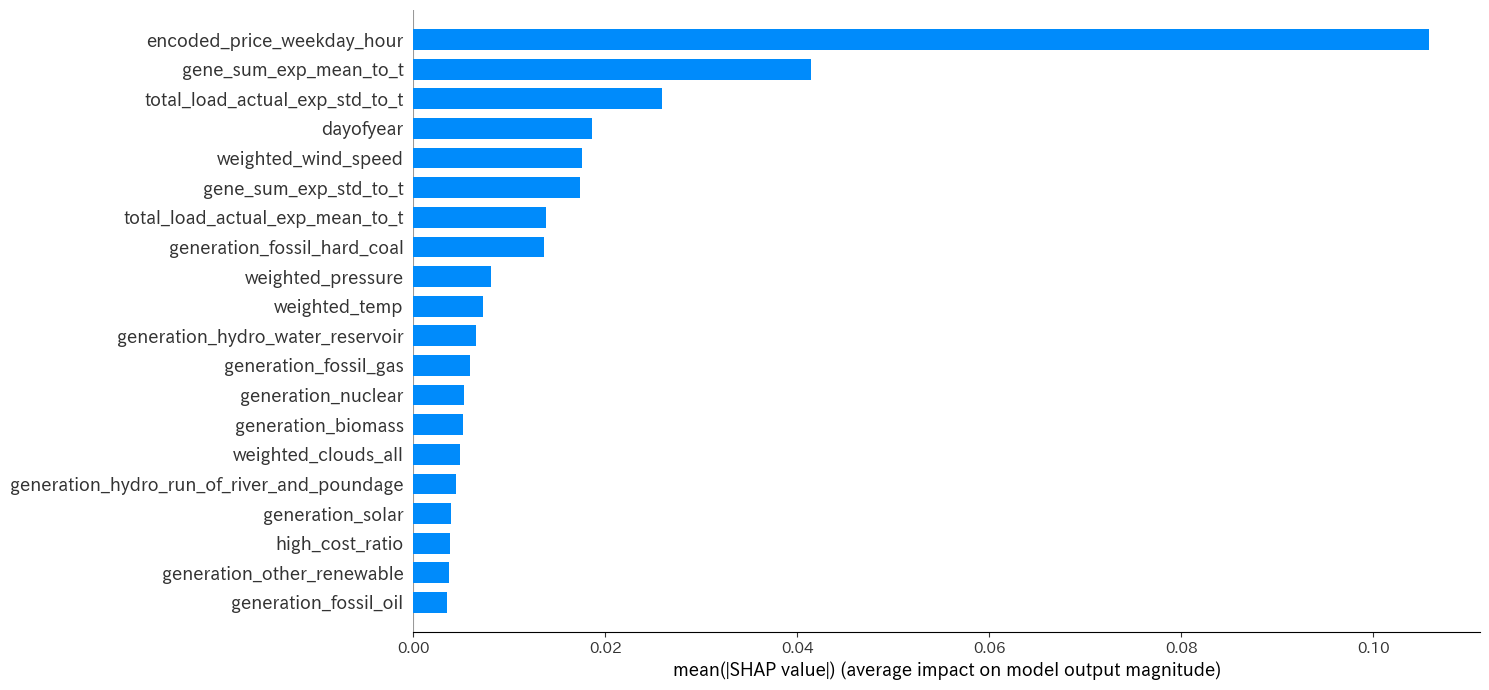

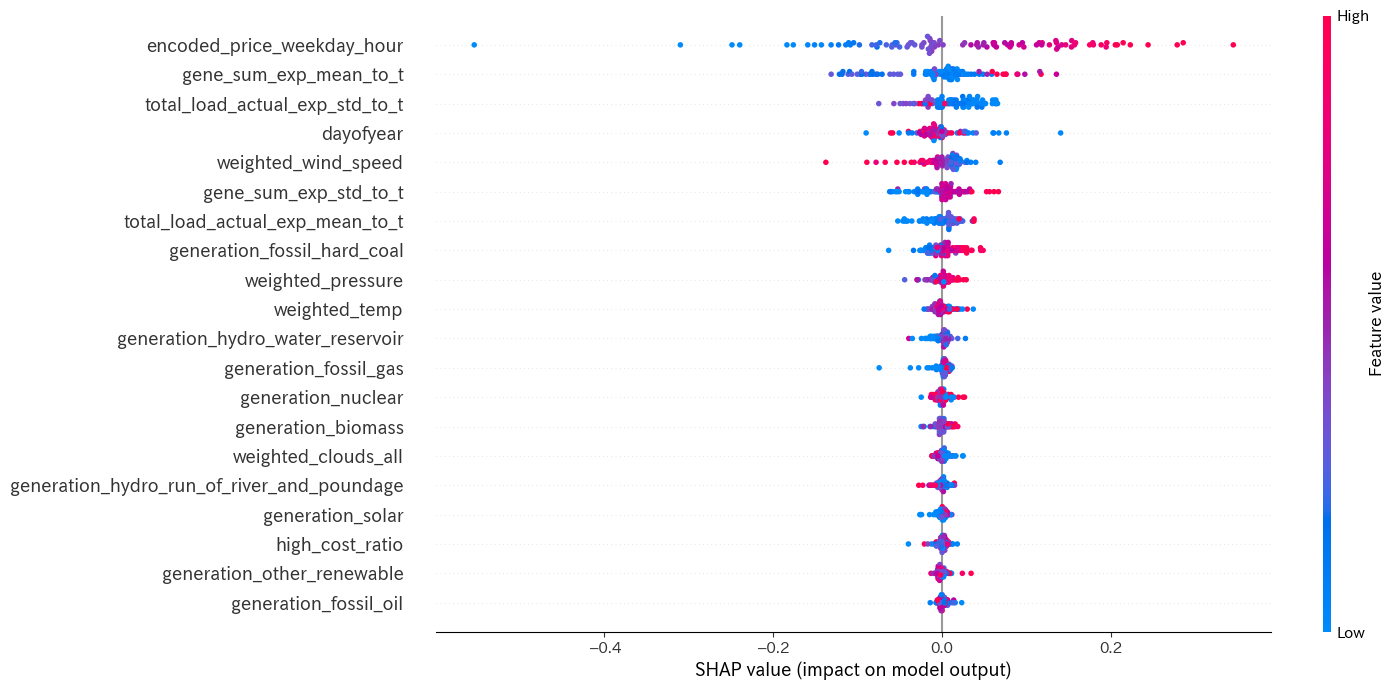

In [102]:
# 特徴量重要度の可視化
shap.summary_plot(shap_values, shap_sample, plot_type='bar', plot_size=(15, 7))
shap.summary_plot(shap_values, shap_sample, plot_size=(15, 7))

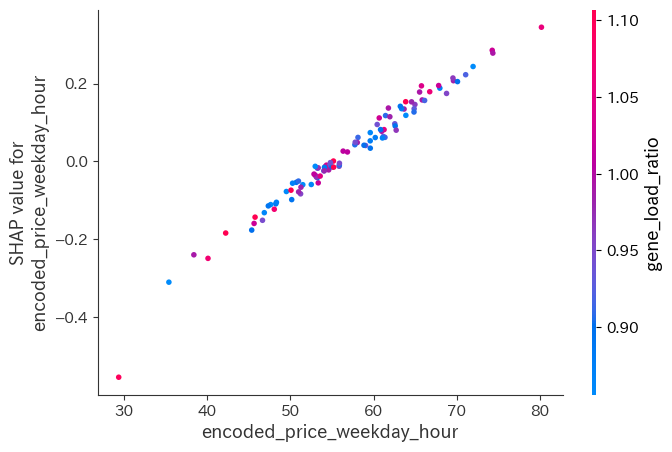

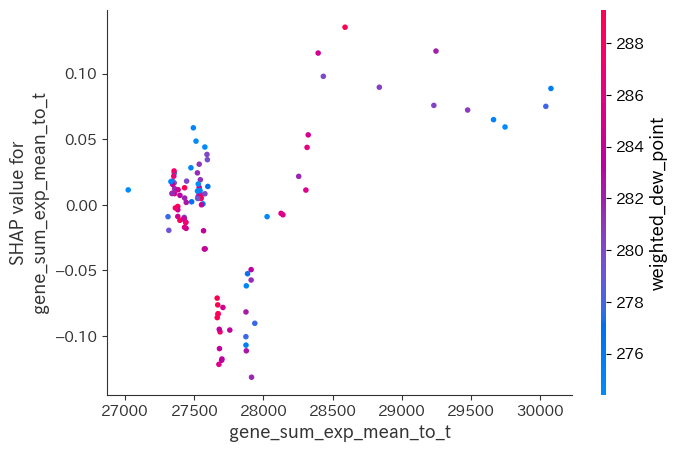

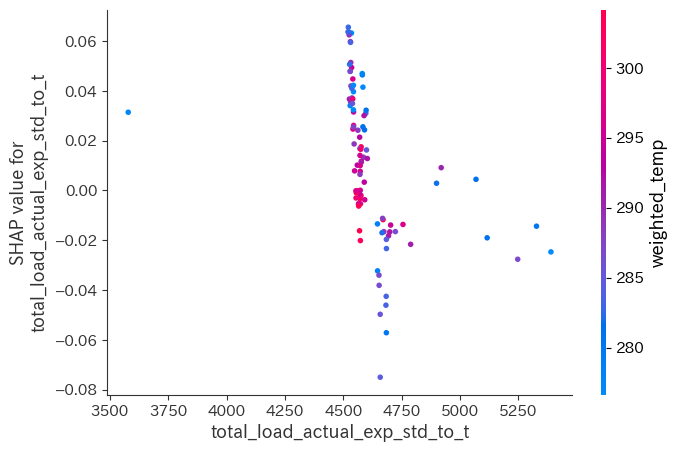

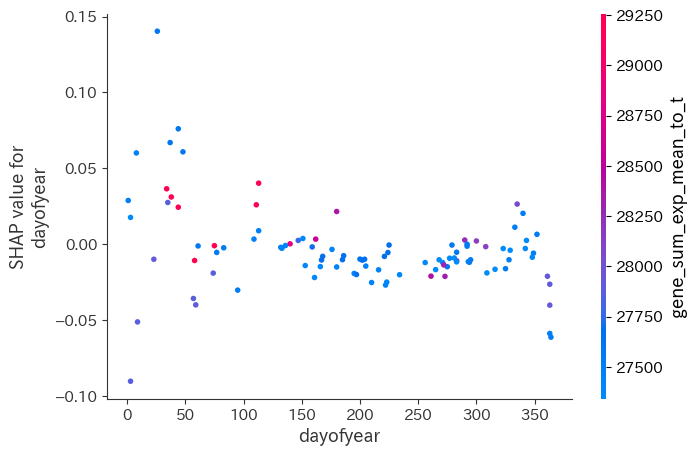

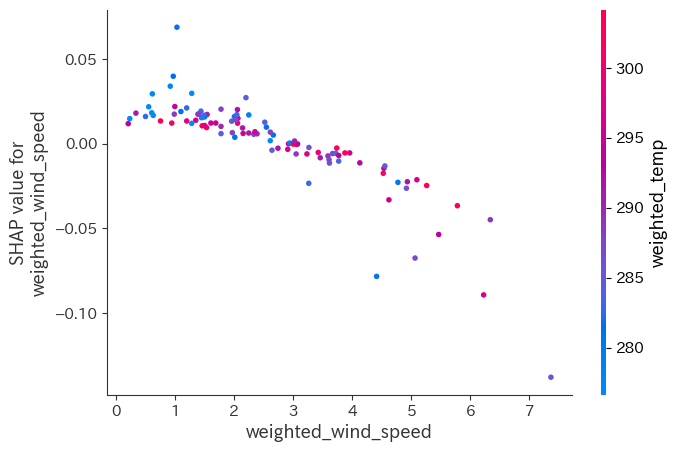

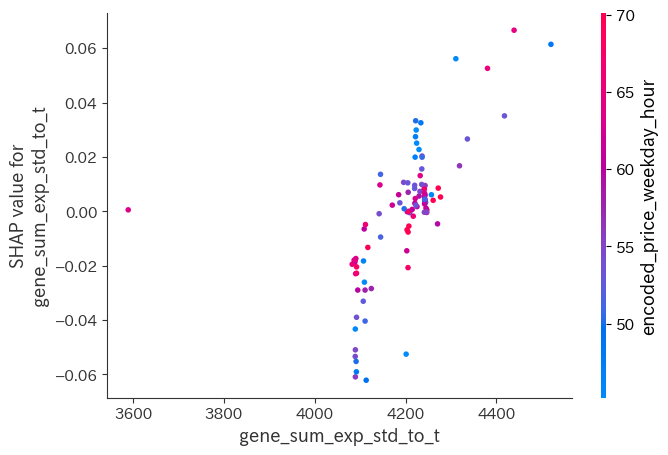

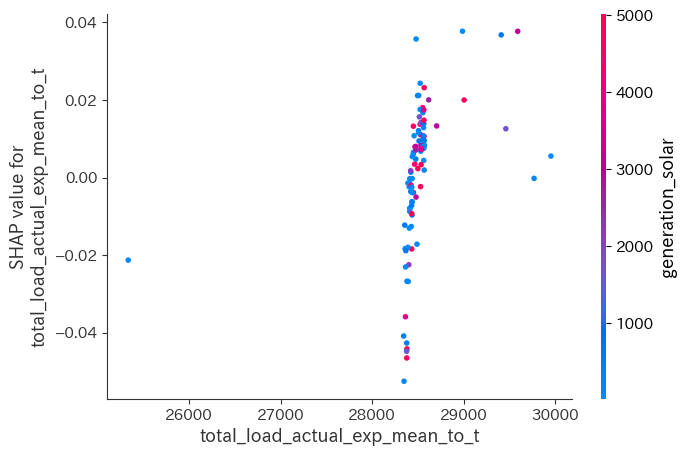

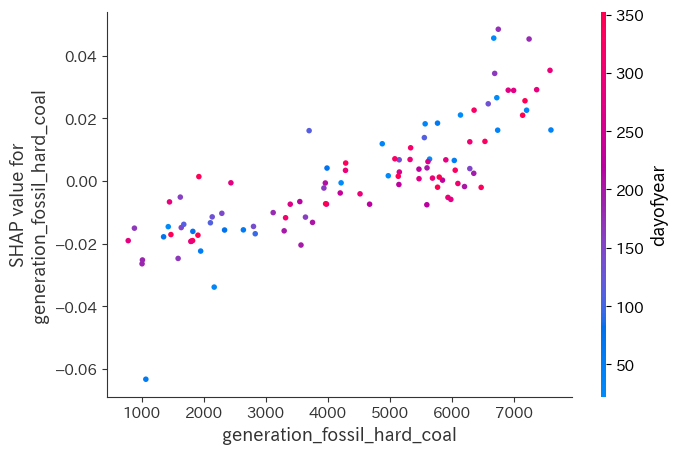

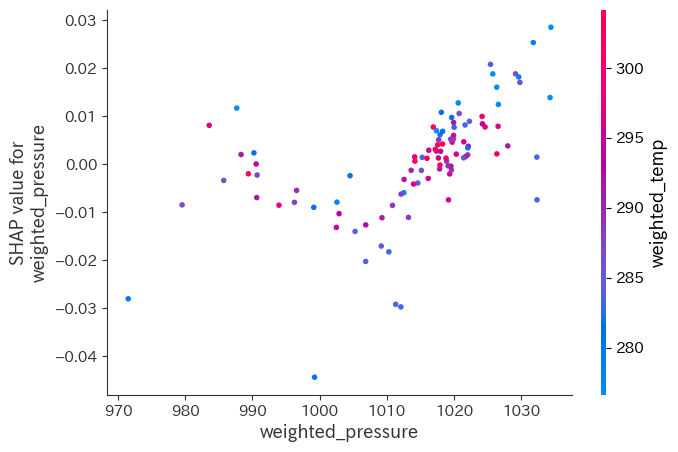

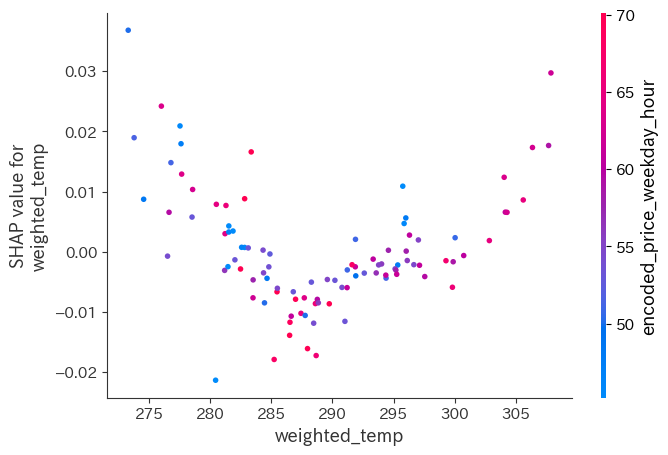

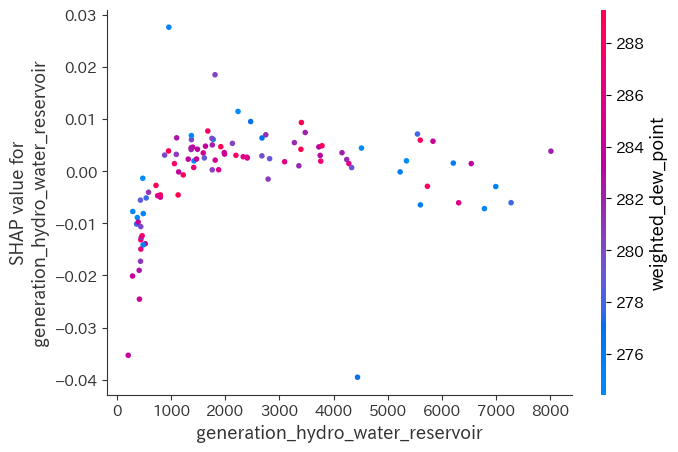

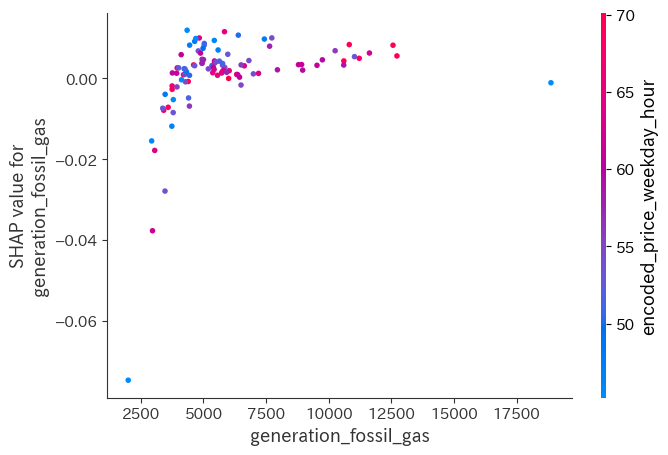

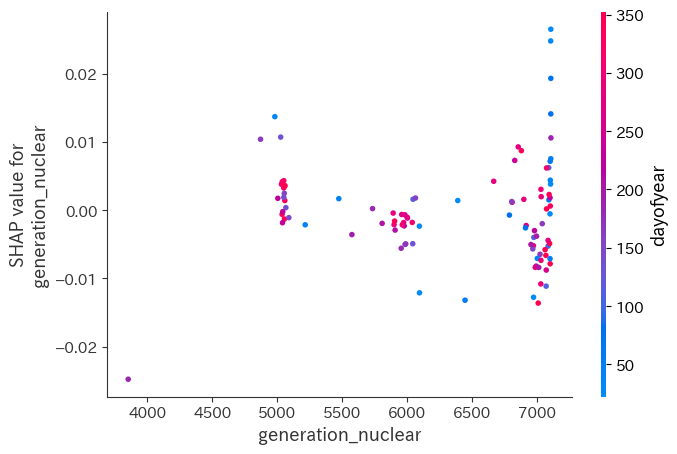

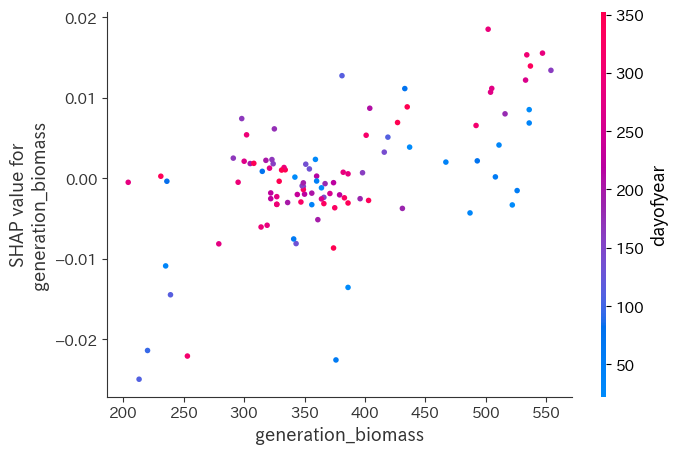

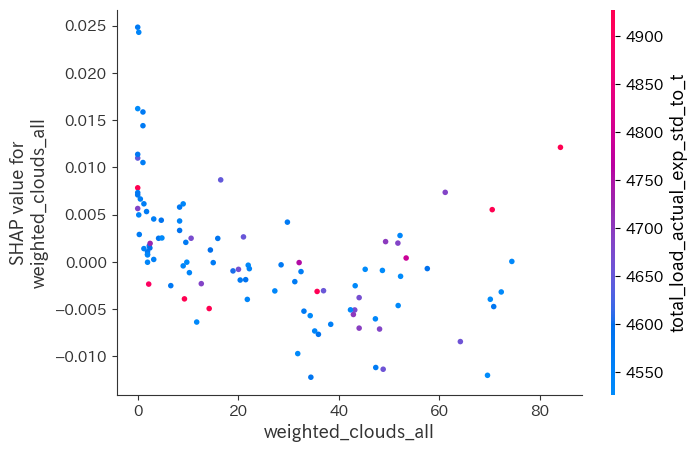

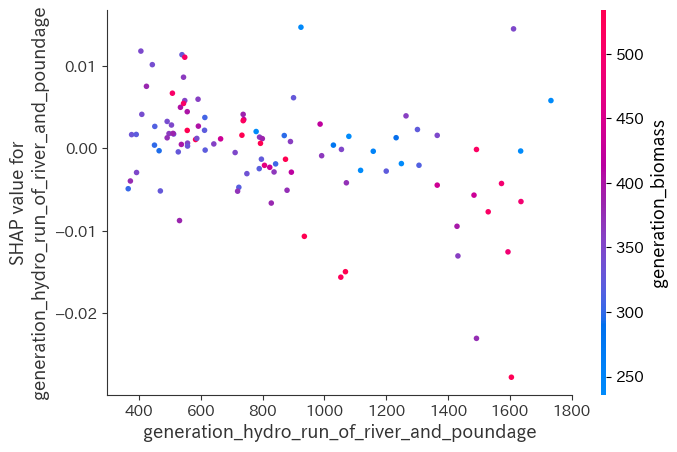

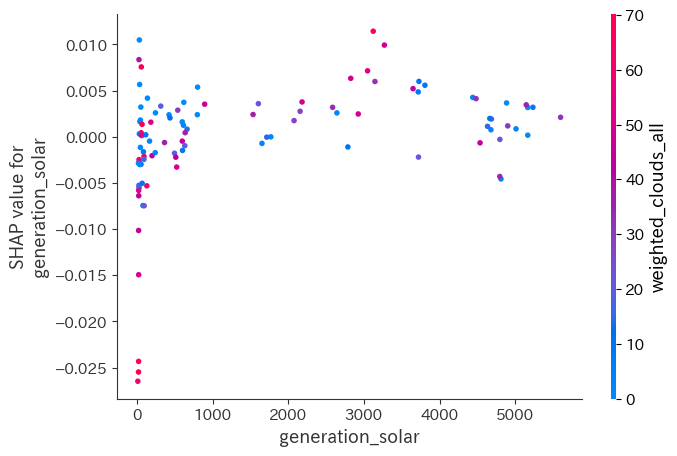

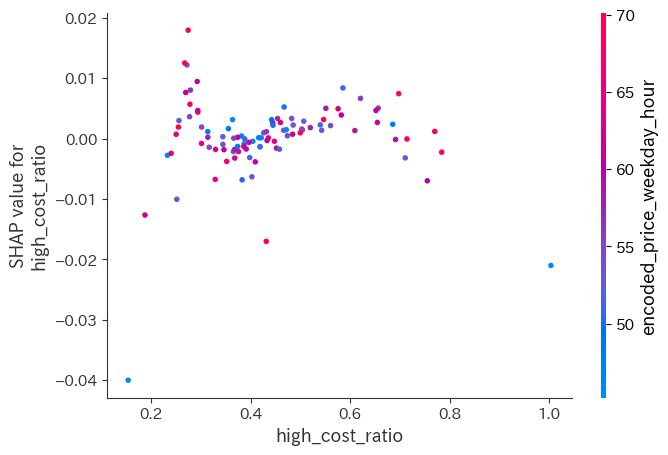

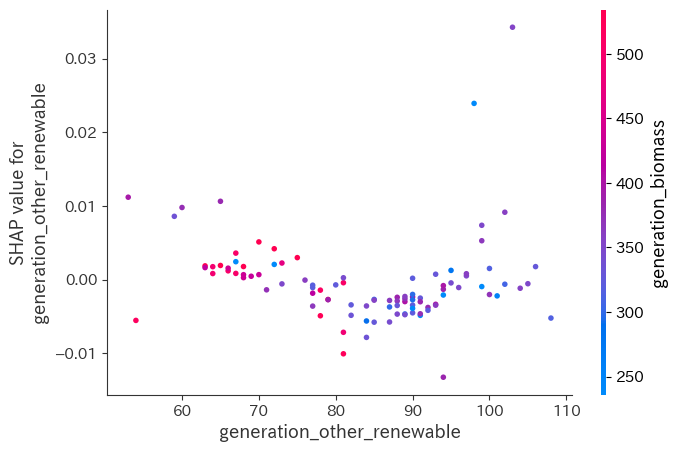

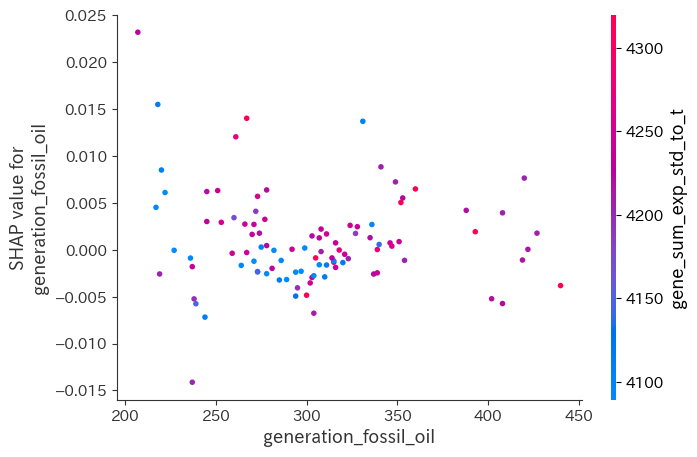

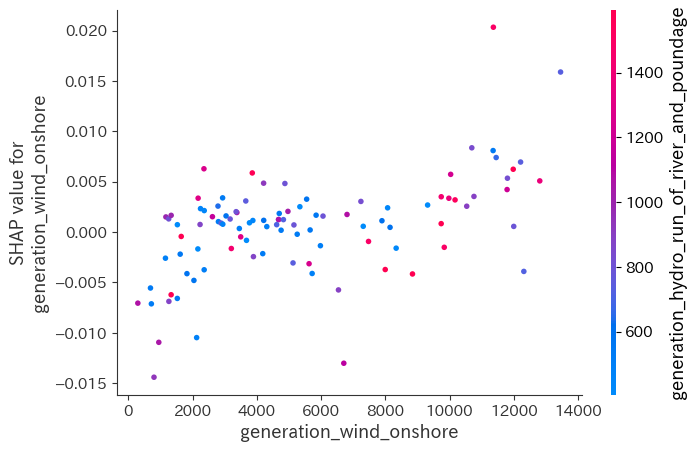

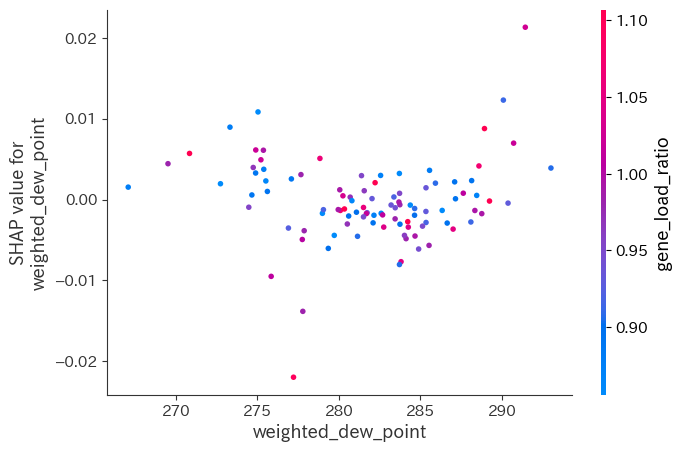

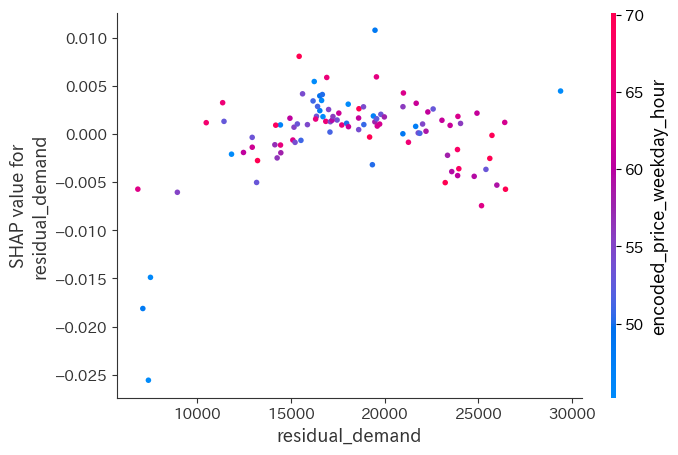

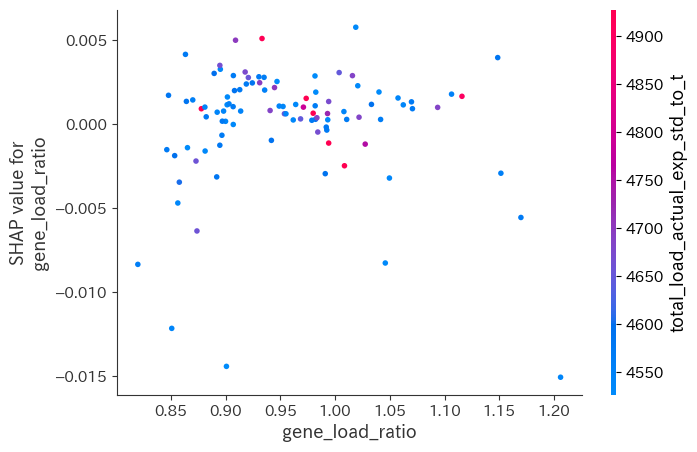

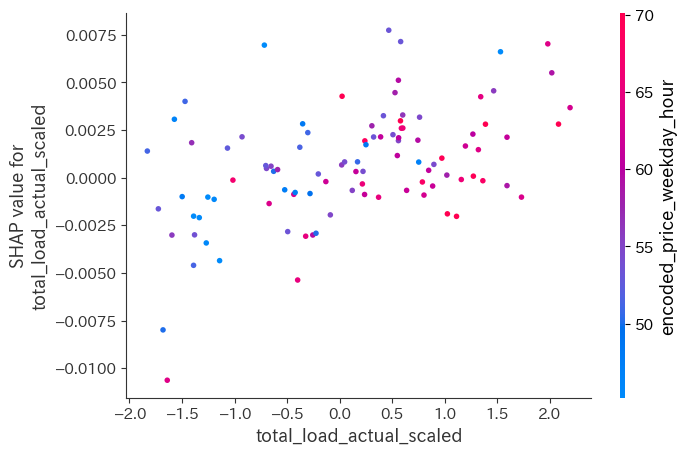

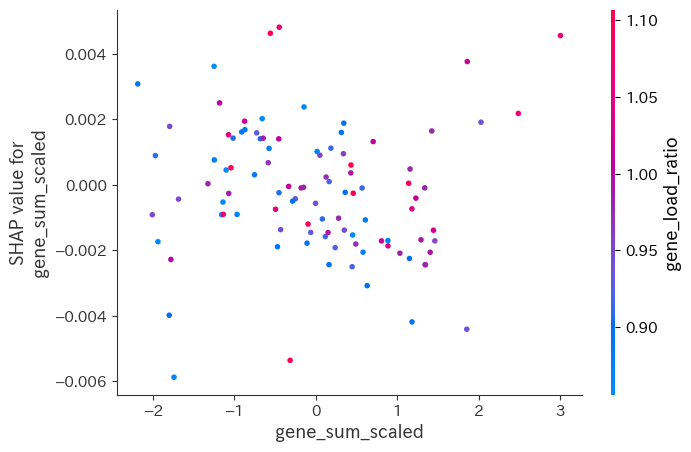

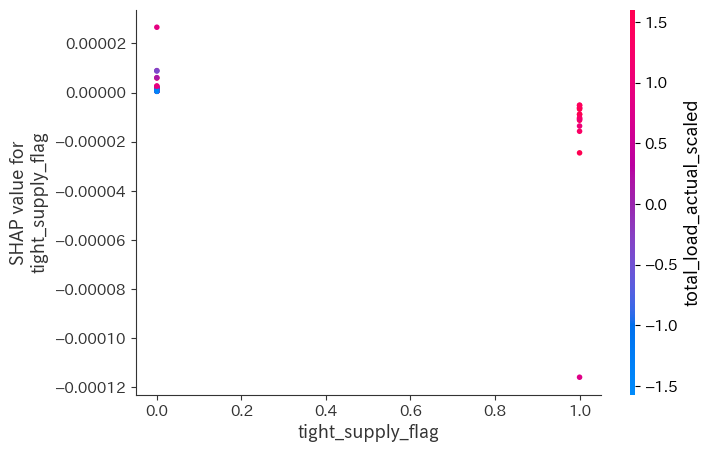

In [103]:
# 特徴量値の変化に応じた変化を描画
for feature in shap_importance['特徴量']:
    shap.dependence_plot(feature, shap_values, shap_sample)

#### 特徴量の作用

In [104]:
# スケーリングされた値を元のスケールに戻す関数
def _inverse_scale(values, feature_name, scaler_params_path):
    scaler_df = pd.read_csv(scaler_params_path, encoding='utf-8-sig')
    row = scaler_df[scaler_df['特徴量名'] == feature_name]

    if row.empty:
        print(f'スケーリング情報が見つかりません: {feature_name}')
        return values
    
    method = row.iloc[0]['手法']

    if method == 'std':
        mean = row.iloc[0]['mean']
        std = row.iloc[0]['std']
        return values * std + mean
    

# 学習時の特徴量のリストを取得する
def _get_model_features_for_pdp(model):
    if isinstance(model, lgb.Booster):
        return model.feature_name()
    else:
        return None


# PDPを描画する関数
def _drew_pdp(df, model_features, feature_name, pred_func, title_suffix='', num_grid_points=50, scaler_param_path=None):
    pdp_isolated = pdp.PDPIsolate(
        model=None if pred_func else model,
        df=df[model_features],
        model_features=model_features,
        feature=feature_name,
        feature_name=feature_name,
        n_classes=0,
        num_grid_points=num_grid_points,
        pred_func=pred_func
    )

    x_vals = pdp_isolated.feature_info.grids
    y_vals = pdp_isolated.results[0].pdp

    # スケーリングを元に戻す
    if scaler_param_path is not None:
        x_vals = _inverse_scale(x_vals, feature_name, scaler_param_path)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_vals, marker='o', linestyle='-')
    plt.xlabel(feature_name)
    plt.ylabel('予測値')
    plt.title(f'特徴量の作用: {feature_name}_{title_suffix}')
    plt.grid(True)
    plt.show()


# 単一モデルに対してPDPを実施する関数
def plot_pdp(model, features, top10_feature_list, model_name='', num_grid_points=50, scaler_param_path=None):
    model_features = _get_model_features_for_pdp(model)

    def pred_func(_, X):
        if isinstance(model, lgb.Booster):
            return model.predict(pd.DataFrame(X, columns=model_features))
        
    for top_feature in top10_feature_list:
        _drew_pdp(
            features,
            model_features,
            top_feature,
            pred_func,
            title_suffix=model_name,
            num_grid_points=num_grid_points,
            scaler_param_path=scaler_param_path
        )

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 584.49it/s]


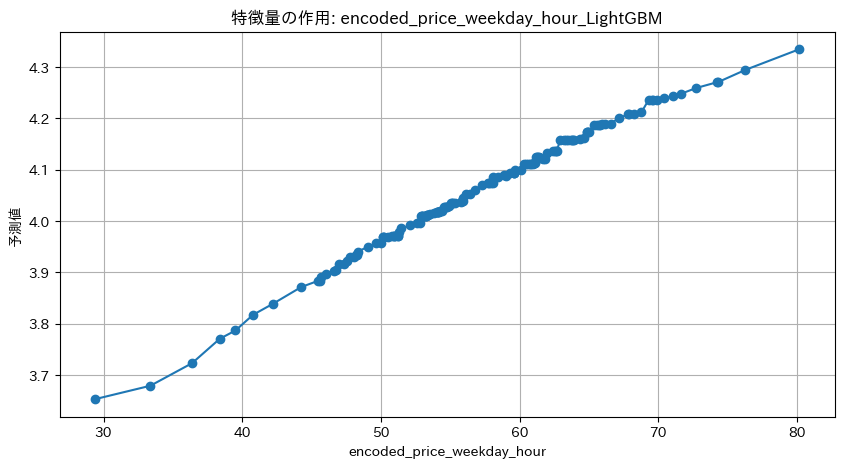

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 540.93it/s]


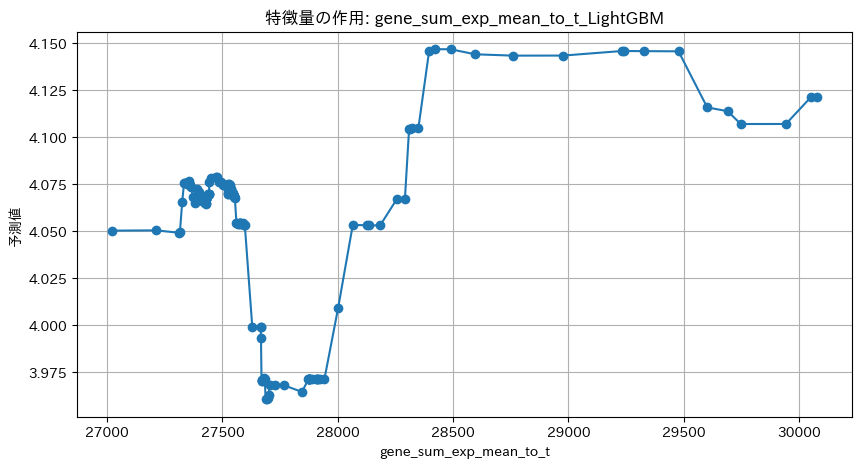

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 584.16it/s]


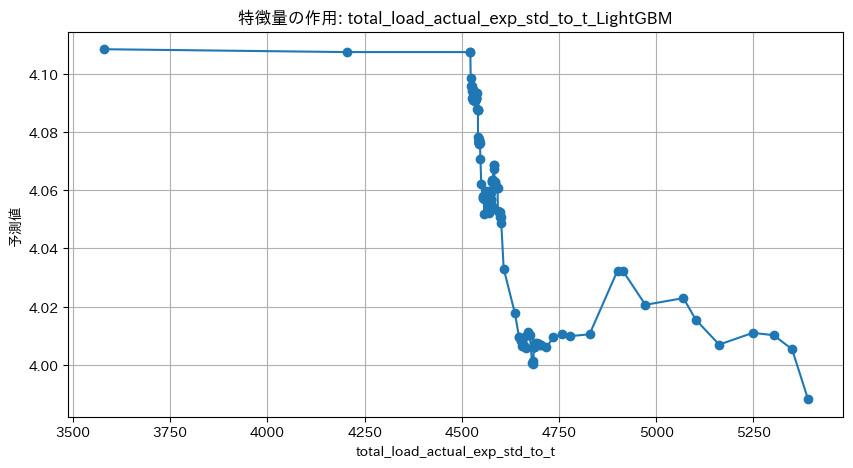

using provided pred_func.


100%|██████████| 142/142 [00:00<00:00, 542.56it/s]


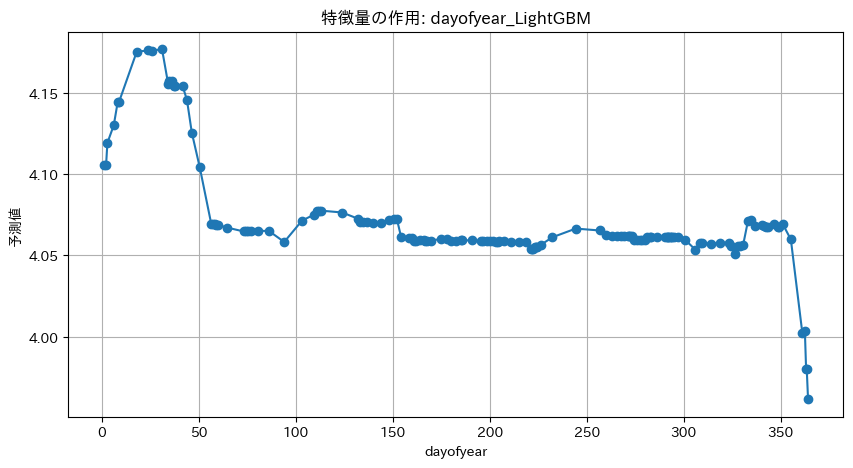

using provided pred_func.


100%|██████████| 147/147 [00:00<00:00, 548.99it/s]


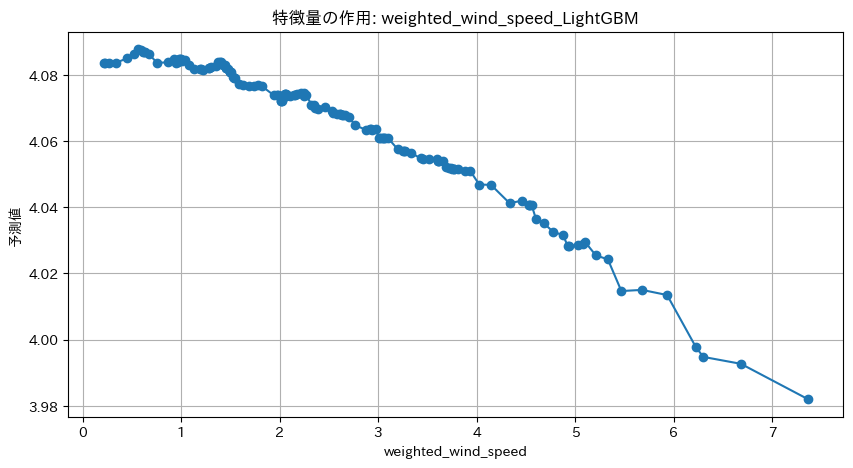

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 561.97it/s]


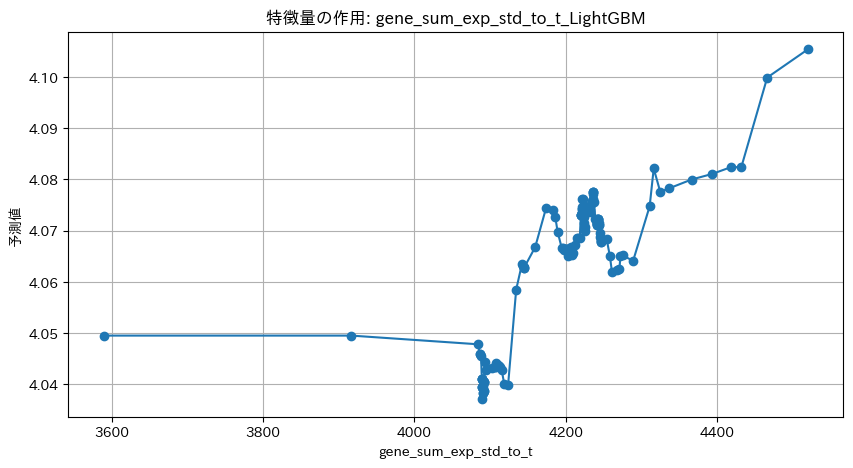

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 541.52it/s]


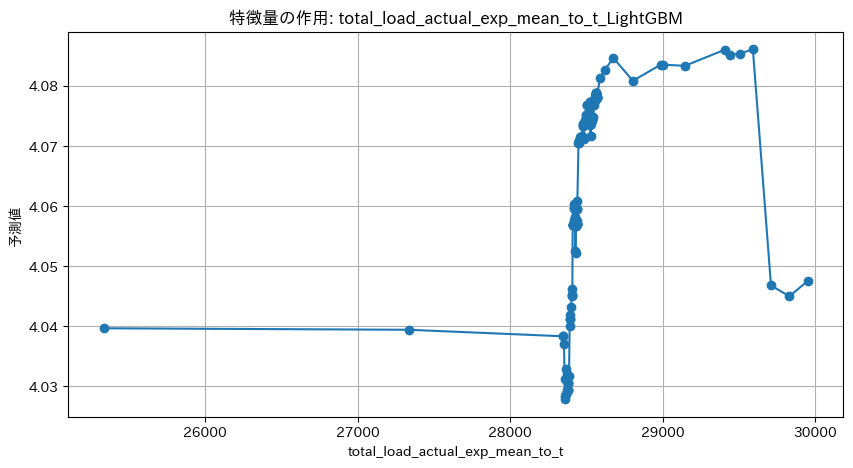

using provided pred_func.


100%|██████████| 149/149 [00:00<00:00, 541.96it/s]


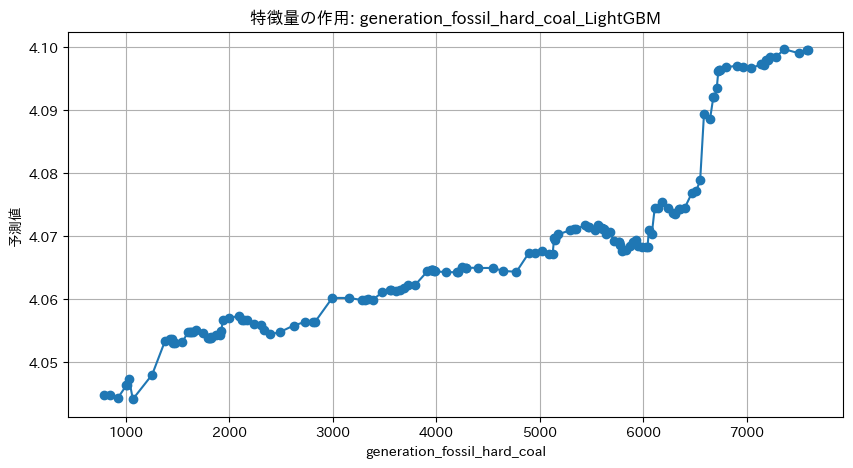

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 573.02it/s]


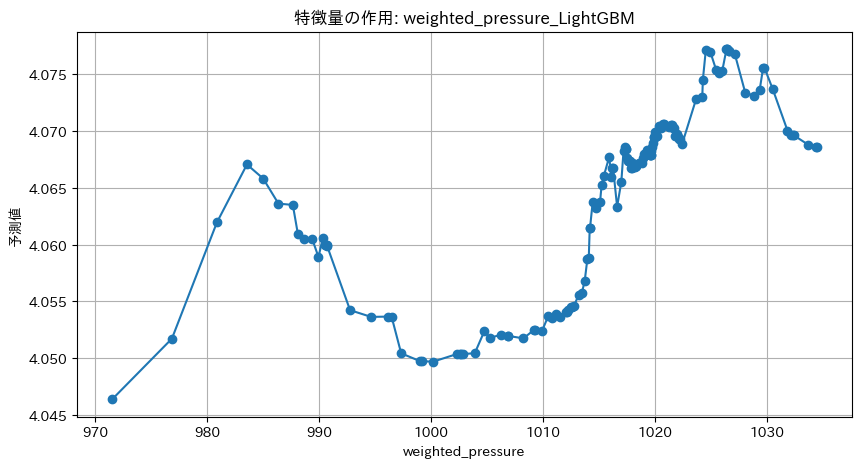

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 575.95it/s]


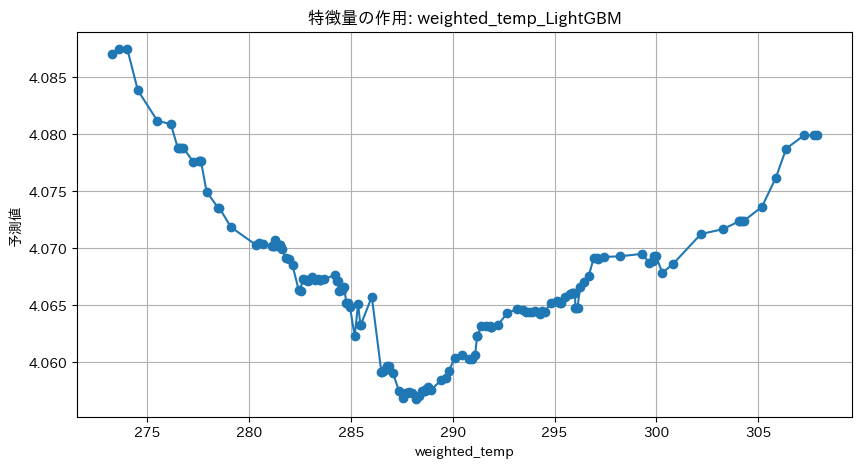

In [105]:
top10_list = shap_importance.iloc[0:10, 0].to_list()
plot_pdp(final_model, shap_sample, top10_list, 'LightGBM', num_grid_points=150, scaler_param_path=None)